```sh
# create windowed bed file with coordinates as center of the peak +- $FLANKS and corresponding sequences
# windows are $BASES wide
FA=/mnt/storage/lab3/Abramov/reference/GRCh37.p13.genome.fa
FLANKS=5000
BASES=300
BED=Caki.narrowPeak
awk -v i=$FLANKS 'BEGIN {OFS="\t"}{print $1, $2+int(($3-$2)/2)-i, $2+int(($3-$2)/2)+i, $4}' $BED | \
        bedtools makewindows -i src -b - -w $BASES | \
            bedtools getfasta -fi $FA -bed - -bedOut > $(basename $)_windowed_seq.bed
```

In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

/home/pavel/miniconda3/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_bed(path):
    my_bed = pd.read_table(path, names=['chr', 'start', 'stop', 'peak', 'sequence', 
                                                                  # 'island', 'lfc'
                                                                 ])
    my_bed['sequence'] = my_bed['sequence'].str.upper()
    # Number of CpG * N / (Number of C * Number of G)
    
    my_bed['obs_exp_ratio'] = (my_bed['sequence'].str.count('CG') * len(my_bed.iloc[0,4])) / (my_bed['sequence'].str.count('C') * my_bed['sequence'].str.count('G'))

    # Zero all Obs/Exp < 0,5
    # my_bed.loc[my_bed['obs_exp_ratio']<0.5, 'obs_exp_ratio'] = 0
    
    # Zero sequences with no C or G content
    my_bed['obs_exp_ratio'].fillna(0, inplace=True)
    # Zero sequences with GC content < 0,5
    my_bed.loc[(my_bed['sequence'].str.count('C') + my_bed['sequence'].str.count('G')) / len(my_bed.iloc[0,4]) < 0.5, 'obs_exp_ratio'] = 0

    sns.boxplot(my_bed['obs_exp_ratio'])
    plt.show()
    
    display(my_bed.head())
    display(my_bed.describe().T)

    return(my_bed)

def sort_bed(my_bed, num_col1, num_col2):
    cg_dens = my_bed.astype(str).groupby(['peak'])['obs_exp_ratio'].agg(','.join).str.split(',', expand=True).astype('float').iloc[:,0:50].fillna(0)
    cg_dens = cg_dens.rolling(3, axis=1, center=True, min_periods=1).mean()
    print(f"Shape of CgG obs/exp matrix: {cg_dens.shape}")
    # sort peaks 
    # peaks with high ratio across center
    # theese peaks are first in order and should represent islands
    # and sorted by peaks across center
    island_peaks = cg_dens[cg_dens.loc[:, num_col1:num_col2].mean(axis=1) >= 0.5].index
    # all other peaks
    # theese peaks should represent shores, shelves and open seas
    # and sorted by all values in a row
    other_peaks = cg_dens.iloc[~cg_dens.index.isin(island_peaks), :]
    other_peaks = other_peaks.mean(axis=1).sort_values(ascending=False).index
    # combine two orders
    order = list(island_peaks) + list(other_peaks)
    cg_dens = cg_dens.loc[order, :]
    display(cg_dens.head(10))
    return(cg_dens)

def plot_heatmap(cg_dens, save_fig_name):
    plt.figure(figsize=(3, 12))
    sns.heatmap(cg_dens, vmin=0.5, vmax=1, annot=False, xticklabels=False, yticklabels=False, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.title("CG observed / CG expected")
    plt.ylabel('Caki Kaiso peaks')
    plt.xlabel('Peak center +- 5kb')
    plt.tight_layout()
    plt.savefig(save_fig_name)
    plt.show()
    return

# 300 bp windows

/tmp/ipykernel_7380/549340511.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  my_bed['obs_exp_ratio'].fillna(0, inplace=True)


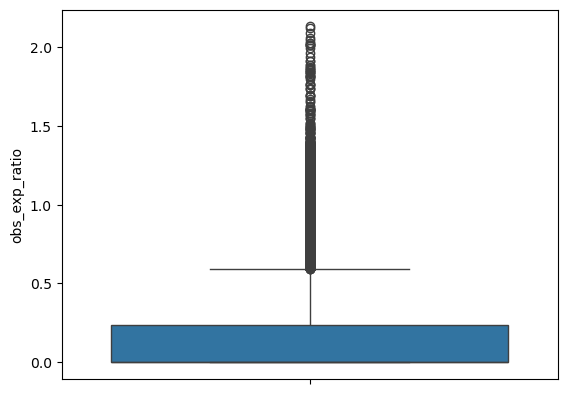

,chr,start,stop,peak,sequence,obs_exp_ratio
0,chr1,46752,47052,true/Caki_Kaiso_peak_3,TACAGGACTTCAAGAACCTTACCTTCTCAACTTTCATCTGCATCTT...,0.0
1,chr1,47052,47352,true/Caki_Kaiso_peak_3,TTACAAAAGATTTGTCCCATGAGTCAAATTTACCACCTCCAGATCT...,0.0
2,chr1,47352,47652,true/Caki_Kaiso_peak_3,ATAGTTATACGAATATCACCATTGCATTAAAGCTCTCTTCCTTGTT...,0.0
3,chr1,47652,47952,true/Caki_Kaiso_peak_3,AAGAGAAATCAATGGAGGCCTGGTTACAAGGATCTAAGAAGCATCA...,0.0
4,chr1,47952,48252,true/Caki_Kaiso_peak_3,CCTCCTATCTCCAATTATTTCAATCCTCAGAGCATTATTCTTACAA...,0.0


,count,mean,std,min,25%,50%,75%,max
start,718896.0,7.841586e+07,5.808025e+07,6910.0,31838907.25,68246076.5,1.168778e+08,2.473399e+08
stop,718896.0,7.841615e+07,5.808025e+07,7210.0,31839207.25,68246376.5,1.168780e+08,2.473400e+08
obs_exp_ratio,718896.0,1.471873e-01,2.580124e-01,0.0,0.00,0.0,2.379379e-01,2.130326e+00


/tmp/ipykernel_7380/549340511.py:28: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  cg_dens = cg_dens.rolling(3, axis=1, center=True, min_periods=1).mean()


Shape of CgG obs/exp matrix: (21144, 34)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
peak,,,,,,,,,,,,,,,,,,,,,
true/Caki_Kaiso_peak_100,0.402883,0.431987,0.447063,0.521954,0.559705,0.566534,0.462206,0.424496,0.500965,0.596994,...,0.137712,0.299833,0.258321,0.324693,0.232265,0.252062,0.218592,0.180985,0.064988,0.048128
true/Caki_Kaiso_peak_10001,0.484135,0.510257,0.464304,0.496116,0.383522,0.327700,0.264633,0.299617,0.371666,0.276003,...,0.584895,0.529740,0.451404,0.471268,0.415002,0.422581,0.226246,0.136778,0.000000,0.000000
true/Caki_Kaiso_peak_10004,0.649161,0.432774,0.361470,0.094937,0.182841,0.228882,0.387110,0.494709,0.531593,0.552791,...,0.561555,0.626201,0.631005,0.611815,0.566555,0.613664,0.608152,0.545618,0.285743,0.195695
true/Caki_Kaiso_peak_10005,0.246711,0.340756,0.456430,0.505860,0.545502,0.548997,0.494977,0.431208,0.435259,0.568577,...,0.628478,0.570202,0.454238,0.207158,0.183936,0.255440,0.425440,0.393075,0.237735,0.101603
true/Caki_Kaiso_peak_10006,0.256057,0.258424,0.299619,0.256140,0.168421,0.091380,0.091380,0.188279,0.298919,0.384941,...,0.629563,0.363503,0.334988,0.333922,0.335430,0.201603,0.255974,0.300403,0.249888,0.164865
true/Caki_Kaiso_peak_10007,0.027022,0.158464,0.158464,0.274618,0.301341,0.450252,0.424443,0.373548,0.224638,0.219983,...,0.276242,0.214946,0.263304,0.394600,0.609550,0.768879,0.796004,0.766508,0.482568,0.382914
true/Caki_Kaiso_peak_10008,0.263736,0.282923,0.445886,0.383441,0.417226,0.355735,0.333861,0.341125,0.425026,0.633468,...,0.428475,0.623960,0.786892,0.791602,0.752660,0.632768,0.513453,0.418078,0.258078,0.230769
true/Caki_Kaiso_peak_10009,0.836931,0.852872,0.964825,0.917502,0.892574,0.876204,0.765588,0.559564,0.367958,0.317004,...,0.456596,0.296346,0.166313,0.191182,0.347164,0.572377,0.709098,0.626507,0.370684,0.193050
true/Caki_Kaiso_peak_10010,0.968417,0.893008,0.890956,0.808863,0.648707,0.365025,0.309188,0.313373,0.337531,0.220030,...,0.195014,0.298211,0.526629,0.695823,0.671295,0.564461,0.411068,0.332652,0.171088,0.079745


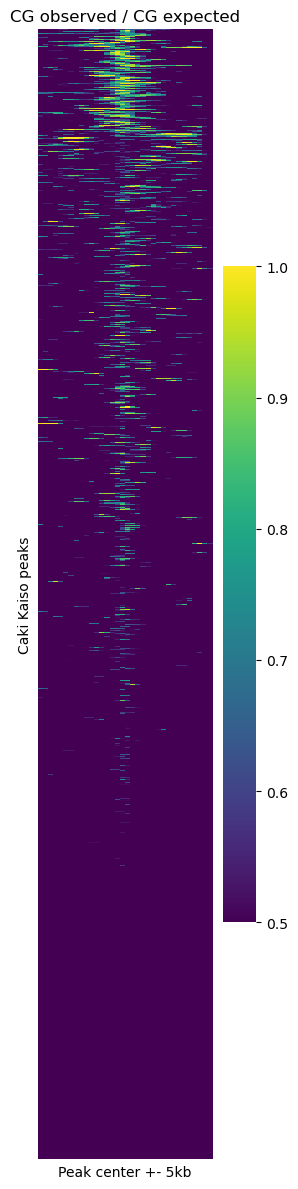

In [3]:
bed300bp = read_bed('Caki_windowed_seq.bed')
cgdens300bp = sort_bed(bed300bp, 10, 20)
plot_heatmap(cgdens300bp, 'my_heatmap.png')